# Hotel Booking Cancellation
### Prepared by Muhammad Naufal Rafi

# Business Problem Understanding

**Latar Belakang:**  
Dewasa ini Seiring berkembangnya teknologi, pada industri hospitality semakin populer pemesanan dilakukan secara online, salah satunya adalah pada industri perhotelan. Online Bookings saat ini sangat memudahkan pengguna dalam memesan sebuah kamar dan juga dengan ini pengguna juga dimudahkan dalam proses pembatalan kamar, hal ini disebabkan karena perilaku pengguna yang melakukan booking secara impulsive yang merupakan dampak negatif dari adanya fitur tersebut. Selain itu adanya biaya pembatalan yang gratis juga yang menyebabkan tingkat pembatalan sering terjadi di industri perhotelan.

Target:  
`0` : Tidak Batal Booking  
`1` : Batal Booking


**Goals:**  
Maka berdasarkan permasalahan tersebut, Perusahaan ingin menganalisa karakteristik seseorang yang melakukan reservasi dengan membuat sebuah model yang mampu memprediksi apakah pelanggan yang telah melakukan reservasi / booking kamar hotel berpotensi untuk melakukan pembatalan booking atau tidak. 

Sehingga pihak hotel dapat mengantisipasi revenue loss pada operasi maupun promosi serta reputasi dari hotel tersebut yang disebabkan dari potensi pembatalan seseorang pelanggan, sehingga pihak hotel akan memfokuskan pada pelanggan yang tidak melakukan pembatalan reservasi.

**Analytical Approach:**  
Jadi pada projek ini akan membangun sebuah model klasifikasi yang mampu membedakan pelanggan yang berpotensi melakukan pembatalan dan tidak dalam reservasi sebuah kamar hotel.

**Metrics Evaluation:**  
- `False Negatives Rate` : Pelanggan yang melakukan pembatalan reservasi hotel namun di prediksi oleh model tidak melakukan pembatalan.  
    - **Konsekuensi:**
        - Pihak hotel telah menyiapkan room dan persediaan yang tidak penting serta pengerahan sumber daya manusia yang sia sia yang akan berujung kepada meningkatnya revenue loss pada pihak perusahaan.
        - Banyaknya kamar dengan status terisi namun kenyataanya kosong, hal ini akan menyebabkan berkurangnya keuntungan pada pihak perusahaan.
        - Berpotensi terjadinya overbooking serta hilangnya peluang dalam menjual kamar hotel kepada pelanggan lainnya.
    - **Solusi:**  
        - Memaksimalkan nilai recall.
- `False Positives Rate` : Pelanggan tidak melakukan pembatalan reservasi hotel namun diprediksi melakukan pembatalan reservasi hotel.
    - **Konsekuensi:**  
        - Tidak adanya persiapan dari pihak hotel dalam mendistribusikan persediaan serta pengerahan sumber daya yang berpotensi terjadinya miss management.
        - Berpotensi hilangnya reputasi baik hotel yang diakibatkan kesalahan hotel karena memberikan kamar hotel kepada pelanggan lain.
    - **Solusi:**  
        - Memaksimalkan nilai precission.

Sehingga dengan demikian sangat penting bagi hotel untuk mengurangi loss revenue serta menjaga reputasi hotel. Jadi pihak perusahaan sangat ingin membuat sebuahmodel yang dapat membedakan kelas positif dan kelas negatif dengan baik, dengan demikian metrics yang akan digunakan adalah `ROC-AUC` dan `Balanced Accuracy`.

**Data Descriptions**

1. `country`: Negara asal pelanggan.
2. `market_segment`: Segmen pasar yang dituju.
3. `previous_cancellations`: Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini.
4. `booking_changes`: Jumlah perubahan/amandemen yang dilakukan pada pemesanan sejak pemesanan dimasukkan ke dalam PMS hingga saat check-in atau pembatalan.
5. `deposit_type`: Indikasi apakah pelanggan melakukan deposit untuk menjamin pemesanan.
6. `days_in_waiting_list`: Jumlah hari pemesanan berada dalam daftar tunggu sebelum dikonfirmasi kepada pelanggan.
7. `customer_type`: Tipe pemesanan.
8. `reserved_room_type`: Kode jenis kamar yang dipesan. Kode ditampilkan sebagai pengganti nama untuk alasan anonimitas.
9. `required_car_parking_space`: Jumlah tempat parkir mobil yang diperlukan oleh pelanggan.
10. `total_of_special_request`: Jumlah permintaan khusus yang dibuat oleh pelanggan (misalnya tempat tidur twin atau lantai atas).
11. `is_canceled`: Nilai yang menunjukkan apakah pemesanan dibatalkan (1) atau tidak (0).

In [1]:
# Import Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_predict, train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler

from sklearn.compose import ColumnTransformer
import category_encoders as ce

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV


from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler


from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve


from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv('data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


Sebelum melakukan analisa dan pembuatan model, alangkah baiknya untuk melihat isi dari data yang digunakan.
Dari informasi diatas didapatkan bahwa terdapat total 11 kolom / fitur yang ada pada dataset ini, lalu terdapat setidaknya 2 buah tipe data pada dataset ini yakni numerik dan kategori. Dari informasi tersebut juga didapatkan missing values pada kolom country, sehingga kita perlu melakukan cleaning pada data kita untuk memudahkan dalam mengintepretasikan maupun membuat sebuah model.

In [4]:
display(df.describe(), df.describe(include='object'))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


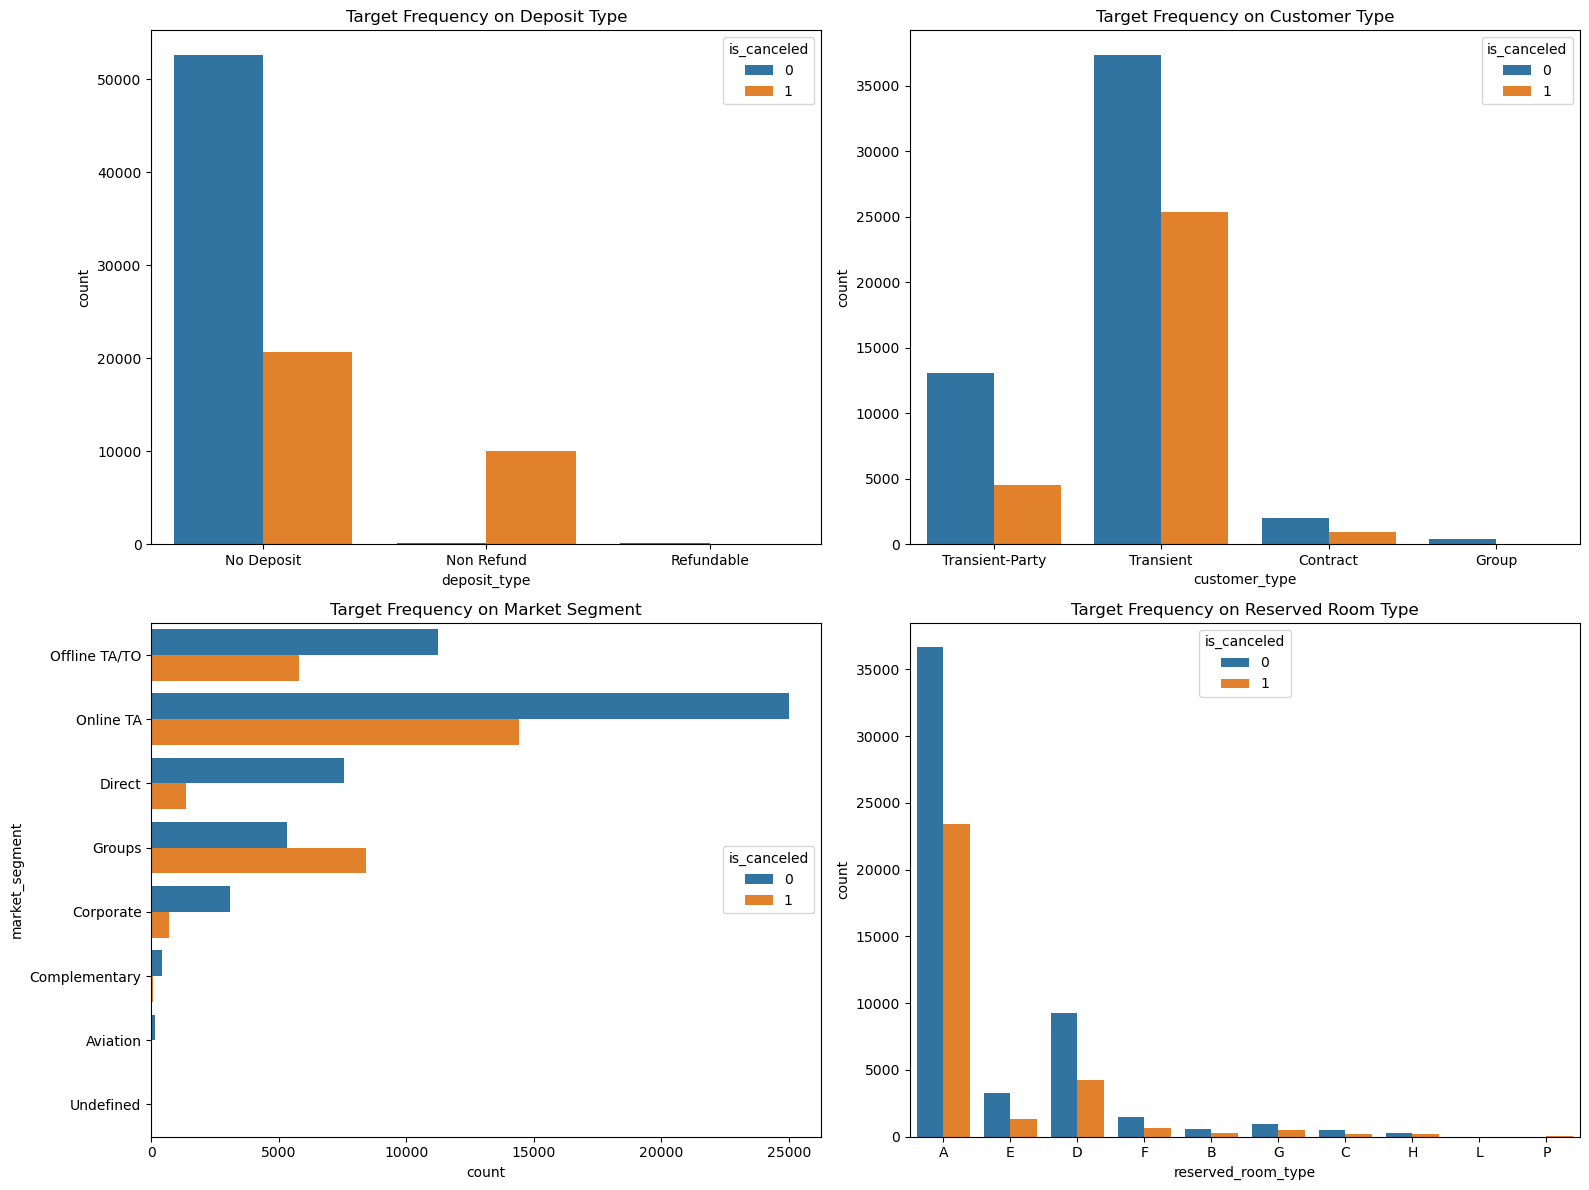

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16,12))

sns.countplot(data=df, x='deposit_type', hue='is_canceled', ax=axes[0,0]).set_title('Target Frequency on Deposit Type')
sns.countplot(data=df, x='customer_type', hue='is_canceled', ax=axes[0,1]).set_title('Target Frequency on Customer Type')
sns.countplot(data=df, y='market_segment', hue='is_canceled', ax=axes[1,0]).set_title('Target Frequency on Market Segment')
sns.countplot(data=df, x='reserved_room_type', hue='is_canceled', ax=axes[1,1]).set_title('Target Frequency on Reserved Room Type')

plt.tight_layout()


Diatas merupakan grafik yang berisikan persebaran data kategorikal berdasarkan jumlah pelanggan yang melakukan pembatalan dan tidak, Dan diperoleh poin poin sebagai berikut:
- Berdasarkan frekuensi target dari deposit type, didapatkan bahwa no deposit cenderung lebih dominan dibanding tipe deposit lainnya. Dan tipe deposit yang paling banyak kasus pembatalannya adalah tipe no deposit, lalu diikuti oleh non refund dan terakhir refundable deposit.
- Untuk target frekuensi berdasarkan customer type, kasus pembatalan didominasi pada tipe customer transient.
- Online TA memiliki frekuensi kasus pembatalan terbanyak dibandingkan market segment lainnya.
- Pada reserved_room_type, room type A memiliki tingkat pembatalan tertinggi. 
- Apa itu reserved room type A, D, dll? kolom ini sebenarnya sedikit rancu karena kurang jelasnya makna dari masing-masing kode kamar, Sehingga nantinya agar kolom ini dapat memberikan insight terhadap model maka akan dilakukan data manipulasi pada kolom tersebut.

# Data Cleaning

In [6]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, B..."
1,market_segment,object,0,0.00,8,"[Offline TA/TO, Online TA, Direct, Groups, Cor..."
2,previous_cancellations,int64,0,0.00,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19,..."
3,booking_changes,int64,0,0.00,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12,..."
4,deposit_type,object,0,0.00,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,int64,0,0.00,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31..."
6,customer_type,object,0,0.00,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,object,0,0.00,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,int64,0,0.00,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,int64,0,0.00,6,"[0, 2, 1, 3, 4, 5]"


Proses diatas dilakukan untuk melihat beberapa variasi data dari seluruh kolom. Dari informasi diats didapatkan sebagai berikut:
- Pada data kategorikal, variabel country memiliki variasi data yang cukup banyak yaitu sebanyak 162 unique data
- Terdapat 351 data yang hilang pada kolom country

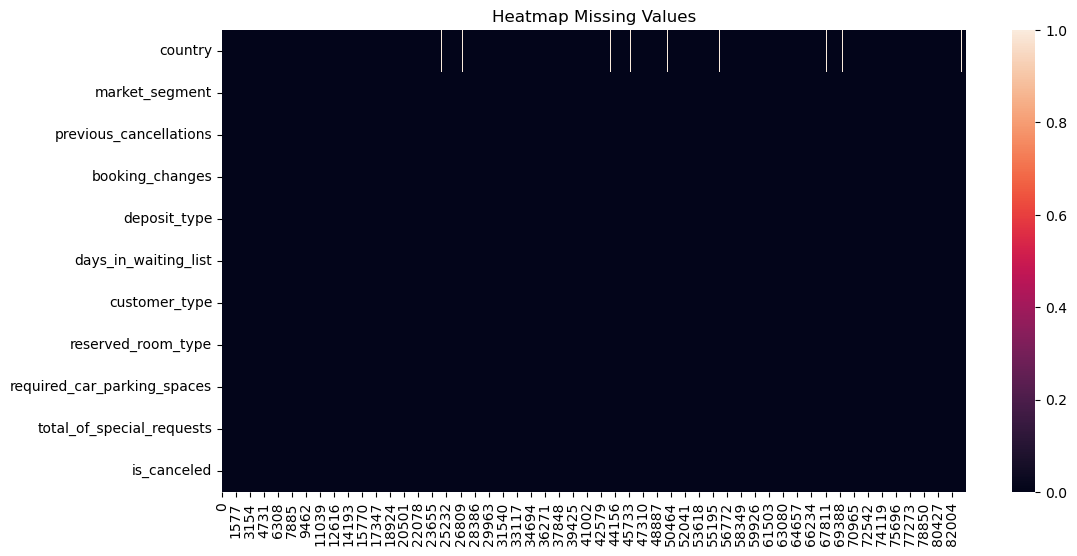

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isna().transpose()).set_title('Heatmap Missing Values');

Dari kedua informasi diatas didapatkan bahwa, terdapat missing values pada kolom / fitur country dengan total missing values sebanyak 351 data atau sebesar 0.42% dari keseluruhan data. Dapat di bilang bahwa data pada kolom country sangat sedikit, sehingga kita akan membuat sebuah kategori baru bernama `unknown` yang merepresentasikan data yang tidak terdapat country di dalamnya.

**Market_Segment**

<AxesSubplot:>

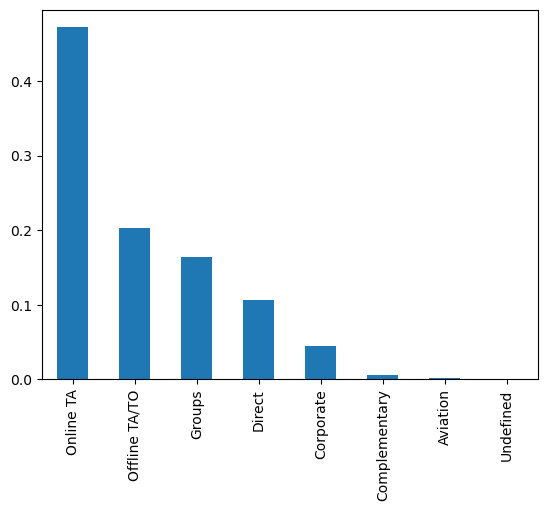

In [8]:
df.market_segment.value_counts(normalize=True).plot(kind='bar')

Variabel market segment berisikan segmen pelanggan yang melakukan booking. Variabel ini terdiri dari 8 kategorikal, dari informasi yang didapatkan dari kolom ini sebenarnya kita dapat membuat sebuah kolom baru serta meringkas beberapa kategori yang terdapat pada kolom ini.

- Membuat kolom baru `booking_type`, yang menandakan customer melakukan booking dengan beberapa metode seperti:
    - online: dilakukan secara daring
    - offline: dilakukan secara langsung / luring
    - other: tidak ada informasi

- Meringkas kategori:
    - Jika diperhatikan terdapat data undefined dengan proporsi yang sangat kecil sehingga kita akan menggunakan data dengan market segment selain dari undefined.
    - Aviation, Complementary dapat digabung dengan Corporate

In [9]:
df = df[df['market_segment'] != 'Undefined']
df['market_segment'] = df['market_segment'].replace('Aviation', 'Corporate')
df['market_segment'] = df['market_segment'].replace('Complementary', 'Corporate')

In [10]:
# Membuat kolom booking type
df['booking_type'] = np.where(df.market_segment == 'Online TA', 'online', np.where((df.market_segment == 'Direct') | (df.market_segment == 'Offline TA/TO'), 'offline', 'other'))

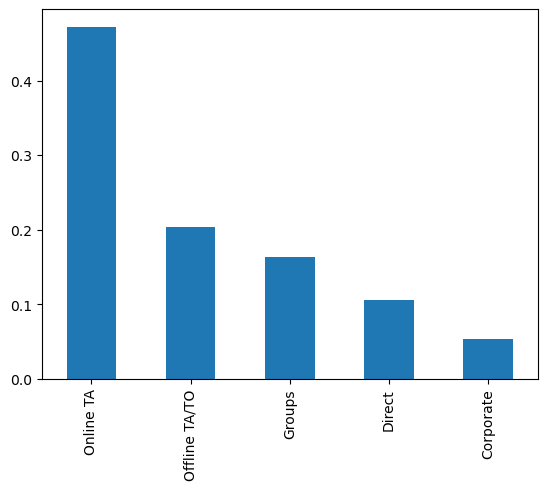

In [11]:
df['market_segment'].value_counts(normalize=True).plot(kind='bar');

**Customer Type**

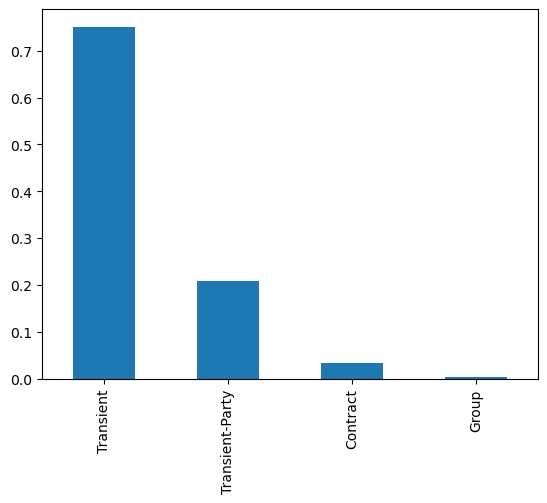

In [12]:
df.customer_type.value_counts(normalize=True).plot(kind='bar');

Jika dilihat dari informasi diatas, variabel ini tidak perlu di ringkas lagi karena masing masing dari kategori sudah cukup jelas.

**Domestic Vs International**

In [13]:
# Mengisi missing values pada country
df['country'].fillna('unknown', inplace=True)

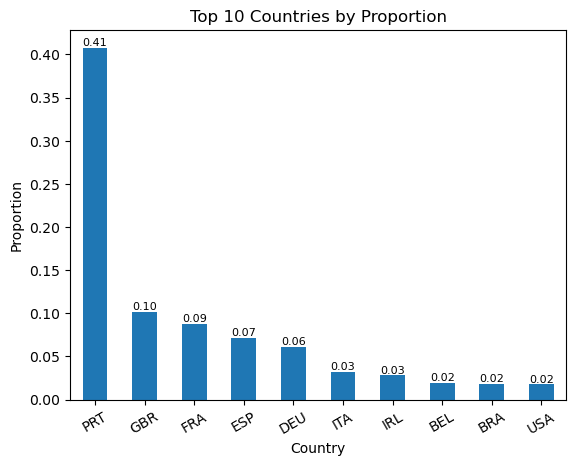

In [14]:
a = df.country.value_counts(normalize=True).sort_values(ascending=False)[:10].plot(kind='bar')

for i in a.containers:
    a.bar_label(i, label_type='edge', labels=[f"{x:.2f}" for x in i.datavalues], fontsize=8)

plt.xlabel("Country")
plt.ylabel("Proportion")
plt.title("Top 10 Countries by Proportion")

plt.xticks(rotation=30)
plt.show()

Berdasarkan negaranya, proporsi portugal sangat besar bahkan lebih besar dibandingkan 2 kali proporsi negara lainnya. Hal ini dikarenakan, dataset berlatar belakang di Portugal sehingga hal tersebut sangat wajar terjadi. Dan karena jumlah unique dari variabel ini cukup banyak yakni sebanyak 162 unique, maka kita dapat meringkas data ini agar lebih mudah untuk dilakukan pemodelan dan mengurangi komplektifitas dari variabel ini yang dapat berpengaruh terhadap hasil prediksi nantinya. Maka dibuatlah kolom baru `is domestic` yang menandakan apakah turis berasal dari portugal atau bukan.

In [15]:
df['is_domestic'] = np.where(df['country']=='PRT', 1, 0)
# domestic tourist di labeli dengan 1 
# international tourist dilabeli dengan 0

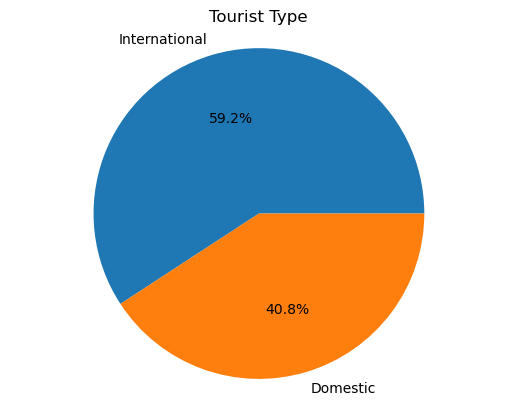

In [16]:
# Jumlah turis internasional dan Domestic
tourist_counts = df['is_domestic'].value_counts(normalize=True)

labels = ['International', 'Domestic']
plt.pie(tourist_counts, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Tourist Type')
plt.show()

Setelah dilakukan manipulasi data, didapatkan bahwa terdapat kurang lebih 60% customer merupakan turis internasional.

**Reserved_room_type**

Reserved_room_type, berisikan kode dari kamar-kamar yang di booking dan diberikan kode secara random / anonimus. Karena kurang nya informasi yang didapatkan dari variabel ini maka akan dilakukan manipulasi data dengan mengelompokkan kode kamar berdasarkan tingkat permintaan kode kamar. Berikut adalah kelompok dari kode kamar tersebut:
- `High Demand`: Permintaan > 10.000
- `Medium Demand`: 1.000 < Permintaan < 10.000 
- `Low Demand`: Permintaan < 1.000

<AxesSubplot:>

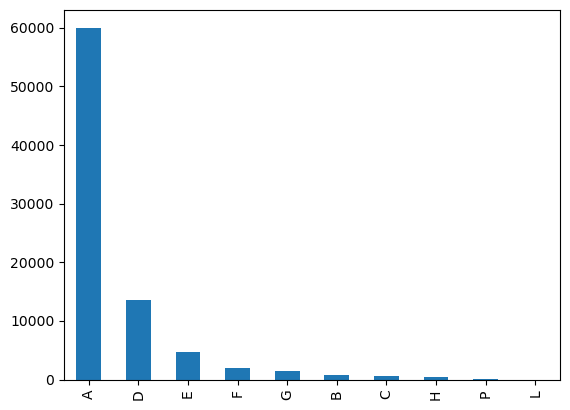

In [17]:
# pd.crosstab(df.reserved_room_type, df.is_canceled)
df.reserved_room_type.value_counts().plot(kind='bar')

Berdasarkan informasi diatas maka dapat disimpulkan:
- `High Demand`: A, D  
- `Mid Demand`: E, F, G  
- `Low Demand`: B, C, H, P , L  

Dari Kolom reserved room type kita akan membagi berdasarkan permintaan dari masing masing kategorikal room type.

In [18]:
df['reserved_room_type'] = np.where((df.reserved_room_type == 'A') | (df.reserved_room_type == 'D'), 'high', np.where((df.reserved_room_type == 'E') | (df.reserved_room_type == 'F') | (df.reserved_room_type == 'G'), 'mid', 'low'))
df['reserved_room_type'].value_counts()

high    73567
mid      8133
low      1872
Name: reserved_room_type, dtype: int64

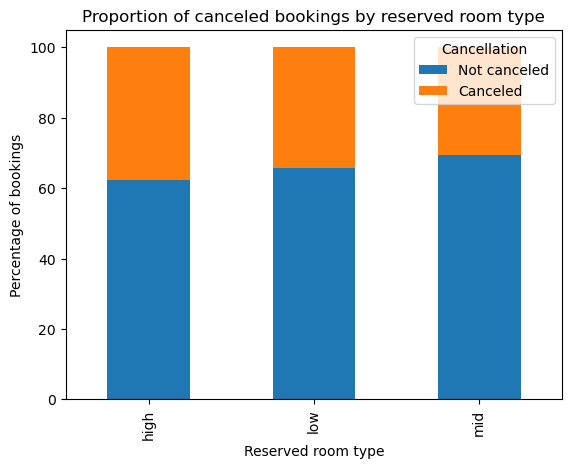

In [19]:
ct = pd.crosstab(df.reserved_room_type, df.is_canceled, normalize='index')*100
ct.plot(kind='bar', stacked=True)

plt.title('Proportion of canceled bookings by reserved room type')
plt.xlabel('Reserved room type')
plt.ylabel('Percentage of bookings')
plt.legend(title='Cancellation', labels=['Not canceled', 'Canceled'])
plt.show()

Diatas terlihat bahwa, proporsi dari tiap kelompok kamar tidak berbeda siginifikan.

**Duplicate Data**

In [20]:
df.drop(columns='country', inplace=True)

Drop variabel `country` dilakukan karena, kolom ini sudah direpresentasikan oleh variabel baru yakni `is_domestic` sehingga kita tidak lagi memerlukan kolom ini untuk melakukan modeling kedepannya.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83572 entries, 0 to 83572
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   market_segment               83572 non-null  object
 1   previous_cancellations       83572 non-null  int64 
 2   booking_changes              83572 non-null  int64 
 3   deposit_type                 83572 non-null  object
 4   days_in_waiting_list         83572 non-null  int64 
 5   customer_type                83572 non-null  object
 6   reserved_room_type           83572 non-null  object
 7   required_car_parking_spaces  83572 non-null  int64 
 8   total_of_special_requests    83572 non-null  int64 
 9   is_canceled                  83572 non-null  int64 
 10  booking_type                 83572 non-null  object
 11  is_domestic                  83572 non-null  int32 
dtypes: int32(1), int64(6), object(5)
memory usage: 8.0+ MB


**Data Description:**

1. `market_segment`: Segmen pasar yang dituju.
2. `previous_cancellations`: Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini.
3. `booking_changes`: Jumlah perubahan/amandemen yang dilakukan pada pemesanan sejak pemesanan dimasukkan ke dalam PMS hingga saat check-in atau pembatalan.
4. `deposit_type`: Indikasi apakah pelanggan melakukan deposit untuk menjamin pemesanan.
5. `days_in_waiting_list`: Jumlah hari pemesanan berada dalam daftar tunggu sebelum dikonfirmasi kepada pelanggan.
6. `customer_type`: Tipe pemesanan.
7. `reserved_room_type`: Kode jenis kamar yang dipesan. Kode ditampilkan sebagai pengganti nama untuk alasan anonimitas.
8. `required_car_parking_space`: Jumlah tempat parkir mobil yang diperlukan oleh pelanggan.
9. `total_of_special_request`: Jumlah permintaan khusus yang dibuat oleh pelanggan (misalnya tempat tidur twin atau lantai atas).
10. `is_canceled`: Nilai yang menunjukkan apakah pemesanan dibatalkan (1) atau tidak (0).
11. `booking_type`: Tipe booking yang dilakukan oleh pelanggan dalam memesan kamar.
12. `is_domestic`: Indikasi apakah pelanggan berasal dari dalam negeri atau mancanegara.

In [22]:
print('Total Duplicate Data: ', df.duplicated().sum())
print('Percentage Duplicate Data: ', round(df.duplicated().sum()/len(df)*100, 1))

Total Duplicate Data:  80975
Percentage Duplicate Data:  96.9


Terlihat bahwa terdapat sebanyak 80975 data atau sebesar 96.9% dari total data yang terduplikasi, hal ini dapat terjadi karena pada dataset ini tidak ada nomor unik tiap transaksi booking (ID) ataupun tanggal dilakukannya booking hotel sehingga data berpotensi terjadi duplikasi karena kesamaan data, serta analisa yang kita lakukan bukanlah tipe time series.

Karena tujuan projek kita adalah melakukan prediksi terhadap potensi pembatalan pada booking hotel yang tidak memerlukan timeseries di dalamnya, maka kita dapat mengatasinya dengan melakukan drop terhadap semua data yang terduplikasi namun hanya menyimpan salah satu (unique) data-nya saja, hal ini dilakukan karena kesamaan data sudah cukup mewakili untuk dilakukan analisa / pembuatan model pada dataset tersebut serta meminmalisir terjadinya kebocoran data pada training dan test set yang dapat mempengaruhi hasil dari prediksi model.

Selain itu Hal ini dilakukan juga bertujuan untuk mempersingkat komputasi yang dilakukan oleh perangkat keras dalam memproses hasil akhir.

In [23]:
df = df.drop_duplicates(keep='last')

In [24]:
df.duplicated().sum()

0

In [25]:
len(df)

2597

Setelah dilakukan drop duplikat data, total data yang ada hanya sekitar 2597 saja.

# EDA

### Distribution Data

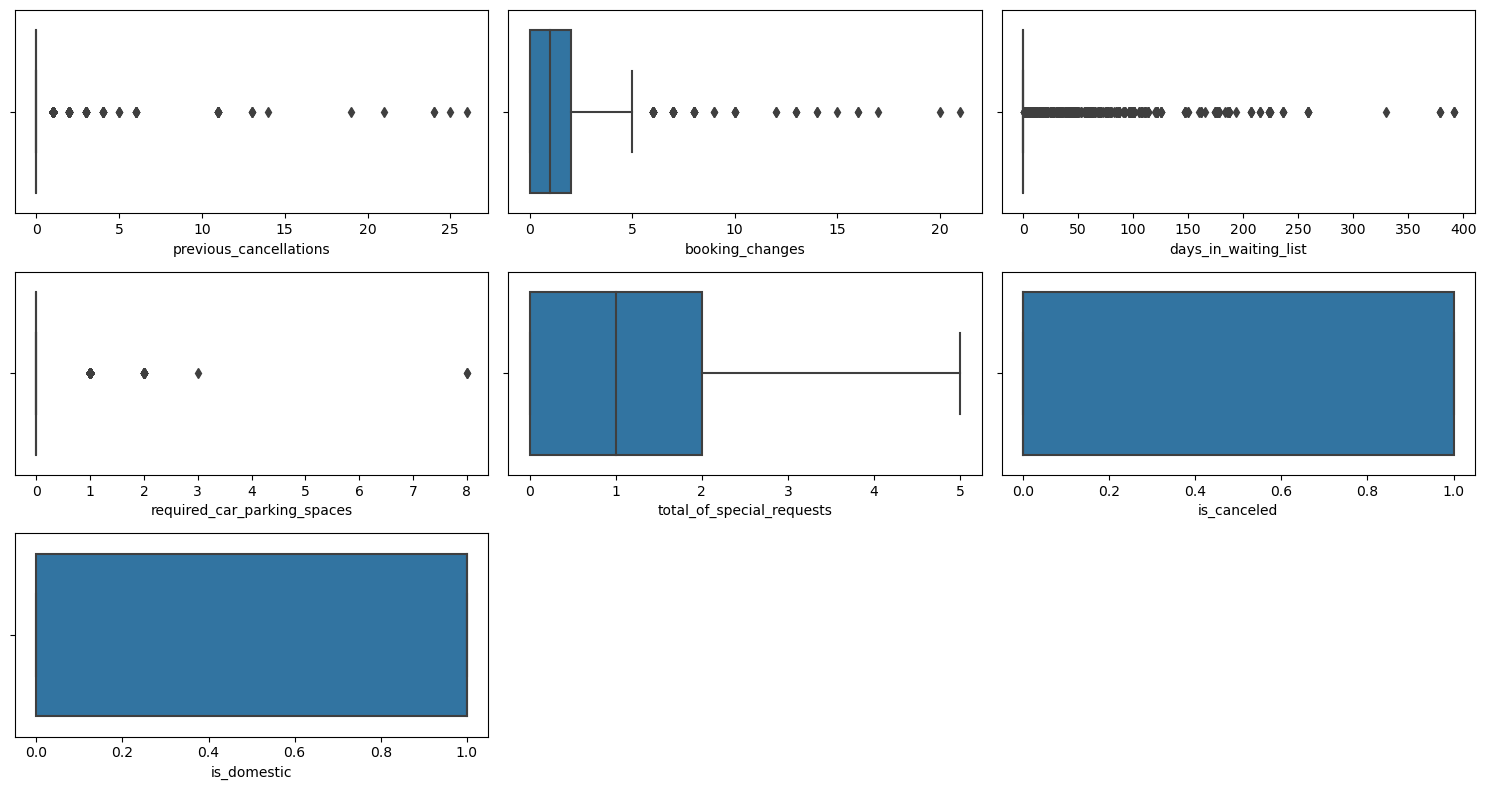

In [26]:
plt.figure(figsize=(15,8))

plotnumber = 1
for kolom in df.describe().columns:

    plt.subplot(3,3, plotnumber)
    sns.boxplot(data=df, x=kolom)

    plotnumber += 1
    
plt.tight_layout()

Dari sini terlihat bahwa, memang persebaran data tiap kolom / fitur numerik cenderung terdistribusi tidak normal. Namun dari data diatas belum terlihat anomali dari persebaran data, sehingga sampai saat ini kita belum akan melakukan treat terhadap outlier.

**Target Distribution**

In [27]:
df.is_canceled.value_counts()

0    1863
1     734
Name: is_canceled, dtype: int64

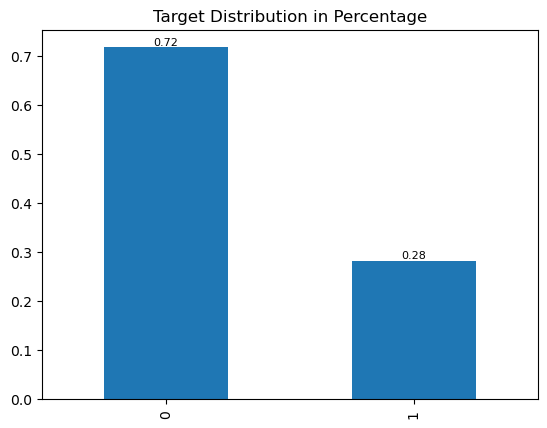

In [28]:
ax = df.is_canceled.value_counts(normalize=True).plot(kind='bar')
plt.title('Target Distribution in Percentage')

for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{x:.2f}" for x in i.datavalues], fontsize=8)

plt.show()

Jika dilihat distribusi target dalam hal ini pembatalan booking pada hotel, terlihat bahwa frekuensi pembatalan lebih sedikit ketimbang yang tidak dibatalkan.

`0 -> tidak batal` : 72%  
`1 -> batal` : 28%

Sehingga dengan demikian dalam membuat sebuah model kedepannya kita perlu mengantisipasi adanya imbalance data untuk menghasilkan output yang tidak bias sehingga mudah untuk di intepretasikan.

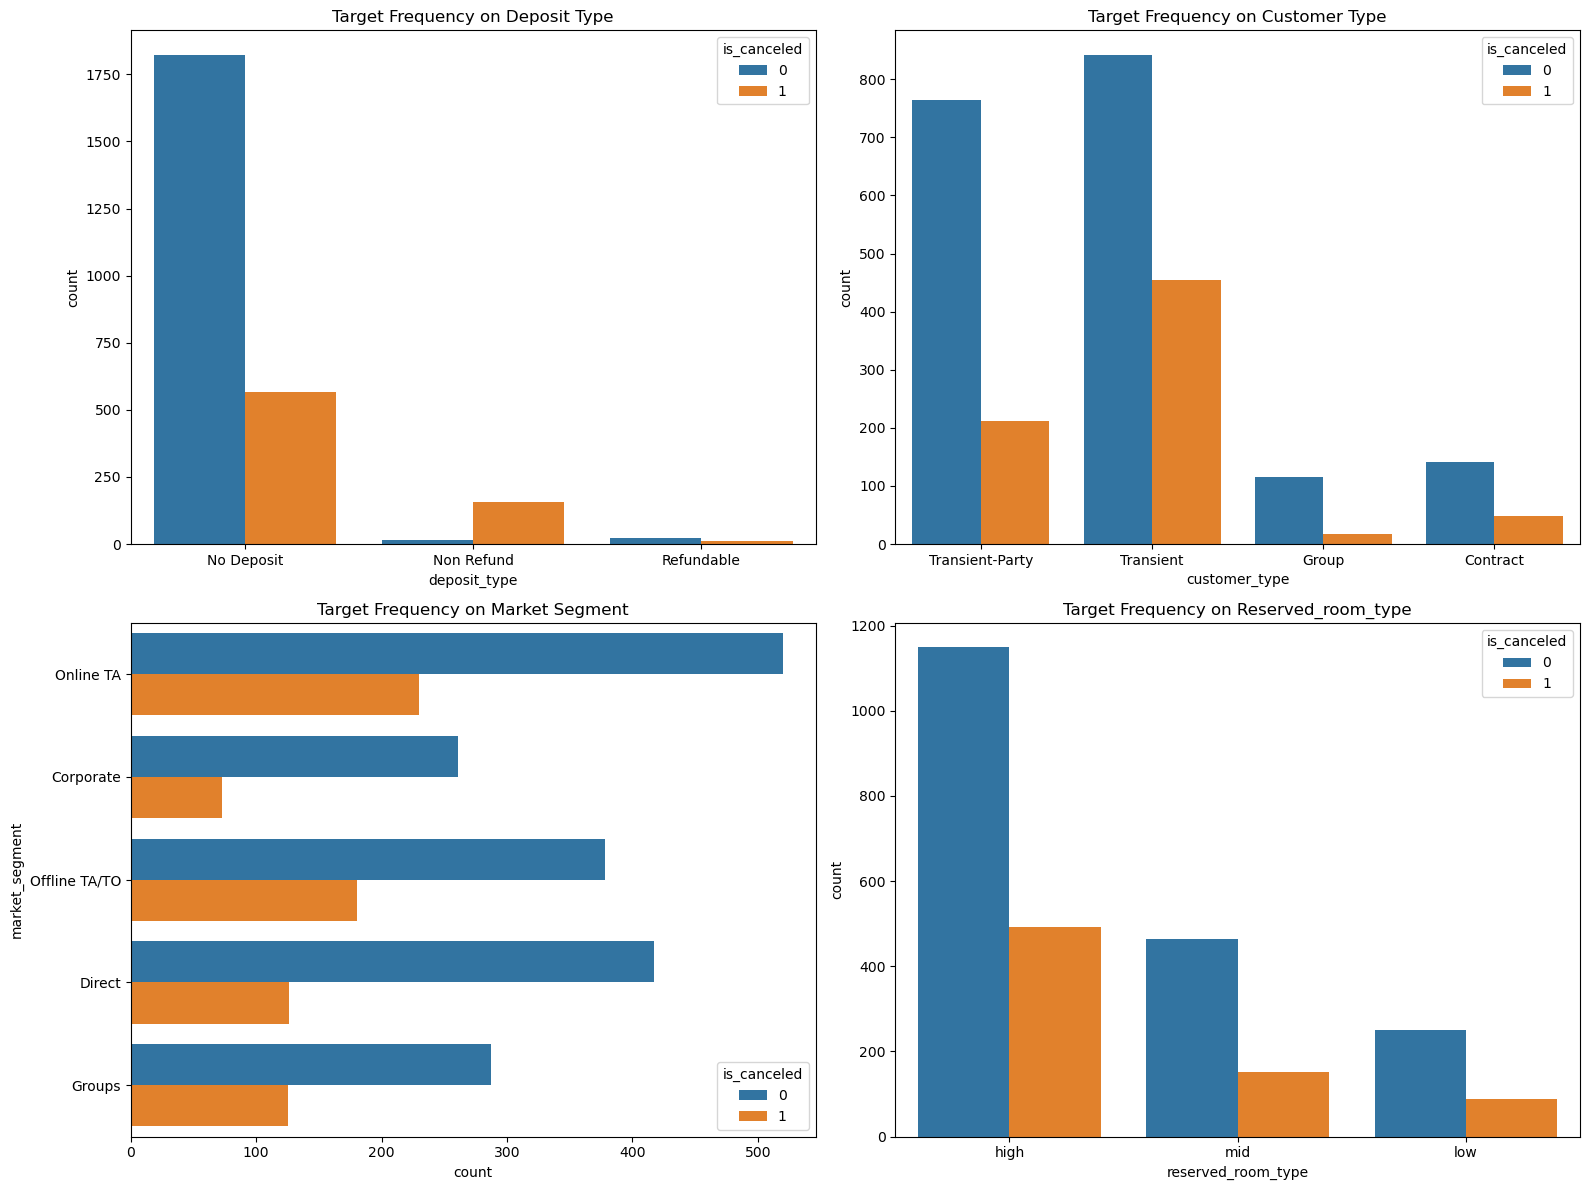

In [29]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

sns.countplot(data=df, x='deposit_type', hue='is_canceled', ax=axes[0,0]).set_title('Target Frequency on Deposit Type')
sns.countplot(data=df, x='customer_type', hue='is_canceled', ax=axes[0,1]).set_title('Target Frequency on Customer Type')
sns.countplot(data=df, y='market_segment', hue='is_canceled', ax=axes[1,0]).set_title('Target Frequency on Market Segment')
sns.countplot(data=df, x='reserved_room_type', hue='is_canceled', ax=axes[1,1]).set_title('Target Frequency on Reserved_room_type')

plt.tight_layout()

Setelah dilakukan cleaning dan manipulasi data didapatkan bahwa:
- Pada reserved_room_type, proporsi dari kamar-kamar favorit cukup besar dibandingkan kelompok kamar lainnya.
- Berdasarkan frekuensi target dari deposit type, didapatkan bahwa no deposit cenderung lebih dominan dibanding tipe deposit lainnya. Dan tipe deposit yang paling banyak kasus pembatalannya adalah tipe no deposit, lalu diikuti oleh non refund dan terakhir refundable deposit.
- Untuk target frekuensi berdasarkan customer type, kasus pembatalan didominasi pada tipe customer transient.

# Feature Selection

In [30]:
df.columns

Index(['market_segment', 'previous_cancellations', 'booking_changes',
       'deposit_type', 'days_in_waiting_list', 'customer_type',
       'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_canceled', 'booking_type',
       'is_domestic'],
      dtype='object')

In [31]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled,is_domestic
count,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000
mean,0.292645,1.277243,12.930304,0.218714,1.006546,0.282634,0.542549
std,1.521493,1.869426,41.404476,0.480662,1.169214,0.450367,0.498282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,0.000000,2.000000,0.000000,0.000000,2.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000,1.000000


In [32]:
df.describe(include='object')

,market_segment,deposit_type,customer_type,reserved_room_type,booking_type
count,2597,2597,2597,2597,2597
unique,5,3,4,3,3
top,Online TA,No Deposit,Transient,high,offline
freq,750,2389,1297,1642,1101


Kolom:
- **country** : Kolom ini berisikan list negara-negara asal dari orang yang booking hotel. Terdapat total 162 negara di dalamnya. Karena jumlah negara yang terlalu banyak, maka kolom ini tidak akan diikutsertakan dalam model machine learning sebagai gantinya kolom ini akan di represenstasikan oleh kolom `domestic_tourist`.
- **market_segment**: Kolom ini berisikan segmentasi dari pengguna hotel. Dengan adanya kolom ini diharapkan mampu memberikan gambaran terkait karakteristik dari setiap segmentasi pengguna hotel dalam potensi terjadinya pembatalan booking.
- **previous cancellations**: Kolom ini merepresentasikan jumlah transaksi booking yang dibatalkan oleh pengguna, sehingga dari kolom ini didapatkan perilaku dari pengguna berdasarkan jumlah pembatalan.
- **booking changes**: Kolom ini berisikan jumlah perubahan booking yang dilakukan pengguna. Kolom ini juga dapat memberikan dampak terhadap revenue hotel.
- **deposit_type** : Kolom ini berisikan tipe deposit yang dilakukan oleh pengguna, Kolom ini dapat memepengaruhi prediksi dari pembatalan hotel dengan memperhatikan karakteristik dari masing masing tipe.
- **previous_cancellations**: Jumlah pembatalan sebelumnya oleh tamu dapat menjadi indikator kecenderungan tamu untuk membatalkan pemesanan di masa depan.
- **days_in_waiting_list**: Jumlah hari tamu menunggu untuk pemesanan dapat menunjukkan seberapa pentingnya pemesanan bagi tamu. Jika tamu telah menunggu lama, mereka mungkin lebih cenderung untuk tetap melanjutkan pemesanan dan tidak membatalkannya.
- **customer_type**: Tipe tamu, seperti tamu individu atau tamu bisnis, dapat mempengaruhi keputusan untuk membatalkan pemesanan.
- **booking_type**: Tipe booking yang dilakukan tamu juga dapat berpengaruh terhadap potensi dari pembatalan.
- **is_domestic**: Ini adalah variabel biner yang menunjukkan apakah pelanggan berasal dari dalam negeri atau luar negeri. Ini dapat memberikan informasi tentang kebutuhan bahasa dan preferensi pelanggan.
- **total_of_special_requests**: Jumlah permintaan khusus yang dibuat oleh pelanggan dapat memberikan informasi tentang preferensi dan harapan pelanggan.
- **required_car_parking_spaces**: Jumlah tempat parkir yang diperlukan oleh pelanggan dapat memberikan informasi tentang tujuan dan kebutuhan pelanggan.

In [33]:
df_copy = df.copy()
# df_copy.drop(columns='country', inplace=True)

df_copy.to_csv('hotel_booking_demand_clean.csv', index=False)

# Split Data

In [34]:
X = df.drop(columns= ['is_canceled'])
y = df['is_canceled']

Karena kita akan melakukan prediksi terhadap apakah seorang tamu akan melakukan pembatalan atau tidak, maka yang menjadi dependent variable pada kasus ini adalah variabel `is_canceled`.

Variabel selain dari `is_canceled` akan dijadikan sebagai independent variable.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2023, test_size=0.2)

In [36]:
display(X_train.shape, y_train.shape)
display(X_test.shape, y_test.shape)

(2077, 11)

(2077,)

(520, 11)

(520,)

Fungsi dari stratify adalah untuk memastikan bahwa data yang digunakan untuk melatih atau menguji model memiliki distribusi kelas atau target yang sama dengan data asli.

# Preprocessing

In [37]:
X.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_domestic
count,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000
mean,0.292645,1.277243,12.930304,0.218714,1.006546,0.542549
std,1.521493,1.869426,41.404476,0.480662,1.169214,0.498282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,2.000000,0.000000,0.000000,2.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [38]:
X.describe(include='object')

,market_segment,deposit_type,customer_type,reserved_room_type,booking_type
count,2597,2597,2597,2597,2597
unique,5,3,4,3,3
top,Online TA,No Deposit,Transient,high,offline
freq,750,2389,1297,1642,1101


In [39]:
transformer = ColumnTransformer([
    ('scaler', RobustScaler(), ['previous_cancellations', 'booking_changes', 'days_in_waiting_list','required_car_parking_spaces', 'total_of_special_requests']),
    ('onehot', OneHotEncoder(drop='first'), ['deposit_type', 'customer_type', 'market_segment', 'reserved_room_type', 'booking_type'])
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', RobustScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['deposit_type', 'customer_type',
                                  'market_segment', 'reserved_room_type',
                                  'booking_type'])])

- `RobustScaler`: scaler yang digunakan untuk melakukan normalisasi pada kolom-kolom numerik tertentu ('previous_cancellations', 'booking_changes', 'days_in_waiting_list','required_car_parking_spaces', 'total_of_special_requests'). Normalisasi dilakukan untuk memastikan bahwa skala dari setiap kolom numerik sama sehingga setiap kolom akan memiliki pengaruh yang setara pada model yang dibangun. RobustScaler dipilih karena ia dapat mengatasi nilai-nilai ekstrem yang mungkin ada dalam data.
- `OneHotEncoder`: encoder yang digunakan untuk melakukan one-hot encoding pada kolom-kolom kategorikal tertentu ('deposit_type', 'customer_type', 'market_segment', 'reserved_room_type', 'booking_type'). One-hot encoding dilakukan untuk mengubah variabel kategorikal menjadi variabel numerik biner agar dapat dimasukkan ke dalam model pembelajaran mesin. Parameter "drop='first'" digunakan untuk menghindari masalah multikolinearitas antar variabel dummy yang dihasilkan oleh encoder.
- Parameter `remainder='passthrough'` digunakan untuk mengabaikan kolom yang tidak dipilih untuk diproses oleh ColumnTransformer. Kolom-kolom yang tidak dipilih akan tetap dijaga dan diteruskan ke dalam model tanpa mengalami transformasi apa pun.

# Modeling Base

In [40]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix
from imblearn.over_sampling import ADASYN

In [41]:
# Models
logreg=LogisticRegression(random_state=2023)
KNN=KNeighborsClassifier(n_neighbors=5)
Tree=DecisionTreeClassifier(random_state=2023)
forest=RandomForestClassifier(random_state=2023)
lgbm=LGBMClassifier(random_state=2023)
gboost=GradientBoostingClassifier(random_state=2023)
adaboost=AdaBoostClassifier(random_state=2023)
xgboost=XGBClassifier(random_state=2023)

# OverSampling
ros = RandomOverSampler(random_state=2023)
smote = SMOTE(random_state=2023)
adasyn = ADASYN(random_state=2023)

# UnderSampling
rus = RandomUnderSampler(random_state=2023)
nearmiss = NearMiss()

# Kfold
skfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

Dalam Benchmarking model, terdapat beberapa evaluasi metriks yang bisa digunakan seperti:
- `ROC AUC`: Metrik evaluasi yang mengukur seberapa baik model dalam membedakan kelas positif dan negatif, yaitu reservasi yang dibatalkan dan yang tidak dibatalkan, pada berbagai threshold. Nilai ROC AUC semakin dekat dengan 1, semakin baik kemampuan model dalam membedakan kelas tersebut.

- `Balanced Accuracy`: Metrik evaluasi yang mengukur seberapa baik model dalam memprediksi kedua kelas dengan seimbang. Nilai balanced accuracy semakin dekat dengan 1, semakin baik kemampuan model dalam memprediksi kedua kelas dengan seimbang.

- `Accuracy`: Metrik evaluasi yang mengukur seberapa banyak prediksi model yang benar dibandingkan dengan total jumlah prediksi. Nilai accuracy semakin dekat dengan 1, semakin baik kemampuan model dalam memprediksi dengan benar.

- `Recall`: Metrik evaluasi yang mengukur seberapa banyak data aktual kelas positif (reservasi yang dibatalkan) yang berhasil diidentifikasi dengan benar oleh model. Nilai recall semakin dekat dengan 1, semakin baik kemampuan model dalam mengidentifikasi data kelas positif.

- `Precision`: Metrik evaluasi yang mengukur seberapa banyak data yang diprediksi kelas positif oleh model yang sebenarnya benar. Nilai precision semakin dekat dengan 1, semakin sedikit data yang salah diklasifikasikan oleh model sebagai kelas positif.

- `F1 Score`: Metrik evaluasi yang menggabungkan precision dan recall dengan mengambil rata-rata harmonik antara keduanya. F1 score semakin dekat dengan 1, semakin baik kemampuan model dalam mengidentifikasi dan memprediksi data dengan benar.



In [42]:
# Tanpa Resampling
from sklearn.metrics import balanced_accuracy_score

models = [logreg, Tree, forest, lgbm, gboost, adaboost, xgboost]
score = []
rata = []
std = []
acc = []
rec = []
prec = []
f1 = []
ba = []

for i in models:
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', i)
    ])
    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    # std.append(model_cv.std())
    acc_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='accuracy')
    acc.append(acc_cv.mean())
    rec_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='recall')
    rec.append(rec_cv.mean())
    prec_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='precision')
    prec.append(prec_cv.mean())
    f1_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='f1')
    f1.append(f1_cv.mean())
    ba_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='balanced_accuracy')
    ba.append(ba_cv.mean())

metrics_df = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LGBM', 'GBoost', 'AdaBoost', 'XGBoost'],
    'mean roc_auc': rata,
    'mean accuracy': acc,
    'mean recall': rec,
    'mean precision': prec,
    'mean f1 score': f1,
    'mean balanced accuracy': ba
}).set_index('model').sort_values(by='mean roc_auc', ascending=False)

metrics_df

,mean roc_auc,mean accuracy,mean recall,mean precision,mean f1 score,mean balanced accuracy
model,,,,,,
GBoost,0.862553,0.792961,0.436042,0.728661,0.542450,0.684800
XGBoost,0.841881,0.748186,0.490526,0.564070,0.523419,0.670095
AdaBoost,0.840397,0.787668,0.453078,0.690940,0.546495,0.686271
Logistic Regression,0.839950,0.779969,0.427597,0.674151,0.523196,0.673194
LGBM,0.837297,0.748182,0.488831,0.565114,0.522106,0.669583
Random Forest,0.766042,0.700529,0.459887,0.470622,0.464046,0.627595
Decision Tree,0.621007,0.685602,0.422440,0.440779,0.430363,0.605851


Diatas adalah hasil benchmark model tanpa menggunakan resampling. Dari tabel tersebut, dapat dilihat bahwa model GBoost memiliki kinerja terbaik dengan `mean roc_auc sebesar 0.862553` dan `mean balanced accuracy sebesar 0.684800`. Namun, keputusan akhir dalam memilih model terbaik juga harus dipertimbangkan berdasarkan faktor lain seperti kebutuhan bisnis, kompleksitas model, dan waktu komputasi yang diperlukan untuk membangun dan melatih model tersebut.

In [43]:
# Ros
from sklearn.metrics import balanced_accuracy_score

models = [logreg, Tree, forest, lgbm, gboost, adaboost, xgboost]
score = []
rata = []
std = []
acc = []
rec = []
prec = []
f1 = []
ba = []

for i in models:
    estimator = Pipeline([
        ('preprocess', transformer),
        ('resample', ros),
        ('model', i)
    ])
    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    # std.append(model_cv.std())
    acc_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='accuracy')
    acc.append(acc_cv.mean())
    rec_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='recall')
    rec.append(rec_cv.mean())
    prec_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='precision')
    prec.append(prec_cv.mean())
    f1_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='f1')
    f1.append(f1_cv.mean())
    ba_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='balanced_accuracy')
    ba.append(ba_cv.mean())

metrics_df = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LGBM', 'GBoost', 'AdaBoost', 'XGBoost'],
    'mean roc_auc': rata,
    'mean accuracy': acc,
    'mean recall': rec,
    'mean precision': prec,
    'mean f1 score': f1,
    'mean balanced accuracy': ba
}).set_index('model').sort_values(by='mean roc_auc', ascending=False)

metrics_df

,mean roc_auc,mean accuracy,mean recall,mean precision,mean f1 score,mean balanced accuracy
model,,,,,,
GBoost,0.859040,0.753491,0.768434,0.546646,0.638170,0.758043
AdaBoost,0.840044,0.752525,0.723917,0.548052,0.623327,0.743838
XGBoost,0.839717,0.739052,0.679820,0.532761,0.596243,0.721118
LGBM,0.838881,0.734708,0.686542,0.524887,0.594021,0.720117
Logistic Regression,0.837881,0.735193,0.764827,0.521443,0.619873,0.744158
Random Forest,0.756171,0.682706,0.528017,0.447814,0.483648,0.635820
Decision Tree,0.619347,0.672592,0.476923,0.428725,0.451058,0.613294


Dari tabel tersebut, dapat dilihat bahwa model GBoost memiliki performa terbaik dalam memprediksi pembatalan reservasi hotel, dengan nilai `rata-rata ROC AUC sebesar 0.859` dan nilai `rata-rata balanced accuracy sebesar 0.758043`. Namun, untuk metrik recall, model Logistic Regression memiliki nilai rata-rata terbaik yaitu 0.765. Sedangkan untuk metrik precision, model XGBoost memiliki nilai rata-rata terbaik yaitu 0.533.

In [44]:
# Rus
from sklearn.metrics import balanced_accuracy_score

models = [logreg, Tree, forest, lgbm, gboost, adaboost, xgboost]
score = []
rata = []
std = []
acc = []
rec = []
prec = []
f1 = []
ba = []

for i in models:
    estimator = Pipeline([
        ('preprocess', transformer),
        ('resample', rus),
        ('model', i)
    ])
    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    # std.append(model_cv.std())
    acc_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='accuracy')
    acc.append(acc_cv.mean())
    rec_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='recall')
    rec.append(rec_cv.mean())
    prec_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='precision')
    prec.append(prec_cv.mean())
    f1_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='f1')
    f1.append(f1_cv.mean())
    ba_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='balanced_accuracy')
    ba.append(ba_cv.mean())

metrics_df = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LGBM', 'GBoost', 'AdaBoost', 'XGBoost'],
    'mean roc_auc': rata,
    'mean accuracy': acc,
    'mean recall': rec,
    'mean precision': prec,
    'mean f1 score': f1,
    'mean balanced accuracy': ba
}).set_index('model').sort_values(by='mean roc_auc', ascending=False)

metrics_df

,mean roc_auc,mean accuracy,mean recall,mean precision,mean f1 score,mean balanced accuracy
model,,,,,,
GBoost,0.861011,0.742407,0.816051,0.529083,0.641774,0.764737
Logistic Regression,0.837252,0.734233,0.771708,0.520198,0.621261,0.745586
LGBM,0.836616,0.719781,0.754614,0.503720,0.603550,0.730327
XGBoost,0.835439,0.719298,0.761495,0.503055,0.605456,0.732090
AdaBoost,0.834064,0.738082,0.718832,0.527193,0.608036,0.732235
Random Forest,0.785090,0.688961,0.739200,0.467974,0.572883,0.704164
Decision Tree,0.683899,0.674993,0.648906,0.448556,0.529995,0.667071


Dari tabel tersebut, kita dapat melihat bahwa GBoost adalah algoritma yang memiliki performa terbaik dalam memprediksi apakah suatu reservasi hotel akan dibatalkan atau tidak, dengan nilai `rata-rata ROC AUC sebesar 0.861011`, `balanced akurasi sebesar 0.764737`, recall sebesar 0.816051, precision sebesar 0.529083, f1 score sebesar 0.641774, dan balanced accuracy sebesar 0.764737.

Jika diperhatikan peningkatan recall terjadi ketika kita tambahkan random oversampling namun nilai precision mengalami penurunan namun tidak signifikan, Hal ini wajar karena oversampling mengubah keseimbangan data sehingga recall dari kelas minoritas meningkat tetapi precisionnya turun. Namun, pada kasus tertentu, nilai recall meningkat lebih banyak daripada penurunan nilai precisio.

Sedangkan Penurunan nilai precision pada kelas mayoritas terjadi karena model memiliki lebih sedikit sampel dari kelas mayoritas yang dapat mempengaruhi pemilihan kelas positif. Dengan jumlah sampel yang lebih sedikit, model memiliki kesulitan dalam mempelajari pola dari kelas mayoritas yang lebih kompleks, sehingga dapat menghasilkan prediksi yang kurang akurat.

<img src="https://3.bp.blogspot.com/--jLXutUe5Ss/VvPIO6ZH2tI/AAAAAAAACkU/pvVL4L-a70gnFEURcfBbL_R-GnhBR6f1Q/s1600/ConfusionMatrix.png" width="500" height="500">

**Bagaimana cara kerja ROC AUC?**  
ROC AUC mengukur seberapa baik model dapat membedakan antara kelas positif dan kelas negatif dengan menghitung luas area di bawah kurva ROC. Kurva ROC menunjukkan hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR) pada berbagai threshold yang berbeda. TPR adalah rasio prediksi benar kelas positif terhadap seluruh data kelas positif, sedangkan FPR adalah rasio prediksi salah kelas negatif terhadap seluruh data kelas negatif. Semakin tinggi nilai ROC AUC, semakin baik kemampuan model untuk membedakan antara kelas positif dan kelas negatif.

<img src="https://developers.google.com/static/machine-learning/crash-course/images/ROCCurve.svg" width="500" height="500">


<img src="http://algolytics.com/wp-content/uploads/2018/05/roc1_en.png" width="500" height="500">

**Bagaimana cara kerja Balanced Accuracy Score?**  
Balanced accuracy adalah rata-rata dari sensitivity dan specificity pada setiap kelas. Sensitivity adalah rasio prediksi benar kelas positif terhadap seluruh data kelas positif, sedangkan specificity adalah rasio prediksi benar kelas negatif terhadap seluruh data kelas negatif. Balanced accuracy mengukur seberapa baik model dapat memprediksi kelas target dengan seimbang pada semua kelas.

<img src="https://stephenallwright.com/content/images/size/w1000/2022/05/Screenshot-2022-05-21-at-15.52.31.png" width="500" height="500">

**Mengapa menggunakan kedua metriks tersebut?** 


Kedua metrik ini saling terkait, karena keduanya mengukur performa model dalam memprediksi kelas target dengan seimbang. Namun, ROC AUC lebih fokus pada kemampuan model dalam membedakan antara kelas positif dan kelas negatif, sedangkan balanced accuracy lebih fokus pada kemampuan model dalam memprediksi kelas target secara seimbang pada semua kelas.

Metrik evaluasi ini bisa diimplementasikan pada dataset Hotel Booking Cancellation dengan melakukan training model machine learning untuk memprediksi apakah booking hotel akan dibatalkan atau tidak. Tujuan dari implementasi ini adalah untuk mendapatkan model yang mampu memprediksi dengan akurat apakah suatu booking hotel akan dibatalkan atau tidak. Dalam hal ini, ROC AUC dan balanced accuracy dapat digunakan sebagai metrik evaluasi performa model untuk memastikan model yang dibangun dapat memprediksi dengan akurat dan seimbang pada semua kelas.

**Model apa yang akan digunakan?**  
Model yang akan digunakan, nantinya berdasarkan hasil predcit model base terbaik yang selanjutnya akan dilakukan hyperparameter tuning untuk menentukan hasil final.

# Predict Model Base

Disini akan dilakukan prediksi dengan menggunakan model sederhana dengan parameter default dari tiap model.

Sebelumnya telah dilakukan crossvalidation pada beberapa model untuk menguji nya dan diperoleh 3 model teratas yang akan digunakan dalam predict ke data test berdasarkan data dengan sampling dan tidak sampling Seperti pada tabel dibawah ini:

**Tanpa Sampling**

| Model  | ROC AUC | Balanced Acc       |
|-------|------|------------|
| GBoost  | 0.862   | 0.6848   |
| XGBoost | 0.841   | 0.6700|
| AdaBoost   | 0.840   | 0.6862    |

**Oversampling**

| Model  | ROC AUC | Balanced Acc       |
|-------|------|------------|
| GBoost  | 0.859040   | 0.758043   |
| AdaBoost | 0.840044   | 0.743838 |
| XGBoost   | 0.839717   | 0.721118    |

**Undersampling**

| Model  | ROC AUC | Balanced Acc       |
|-------|------|------------|
| GBoost  | 0.861011   | 0.764737   |
| Logreg | 0.837332   | 0.746105 |
| LGBM   | 0.836616   | 0.730327    |

Selanjutnya akan dilakukan pengujian seluruh model tersebut dengan menggunakan data test, dan model yang menghasilkan nilai ROC dan Balanced Accuracy terbaik akan digunakan dalam hyperparameter tuning.

## Wihtout Oversampling

GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       373
           1       0.79      0.47      0.59       147

    accuracy                           0.82       520
   macro avg       0.81      0.71      0.74       520
weighted avg       0.81      0.82      0.80       520

Confusion Matrix:


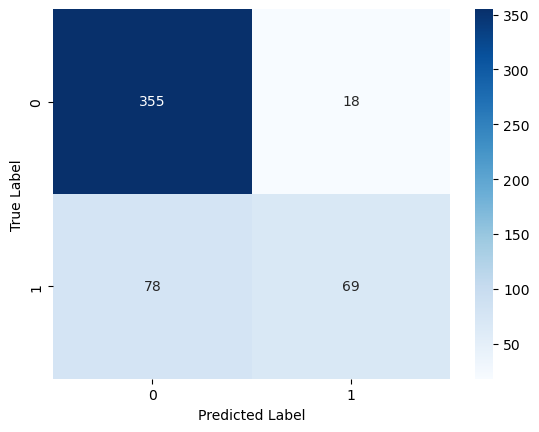

ROC AUC Score: 0.881855154930605
Balanced Acc: 0.7105651912239427


XGBClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       373
           1       0.58      0.48      0.52       147

    accuracy                           0.76       520
   macro avg       0.70      0.67      0.68       520
weighted avg       0.74      0.76      0.75       520

Confusion Matrix:


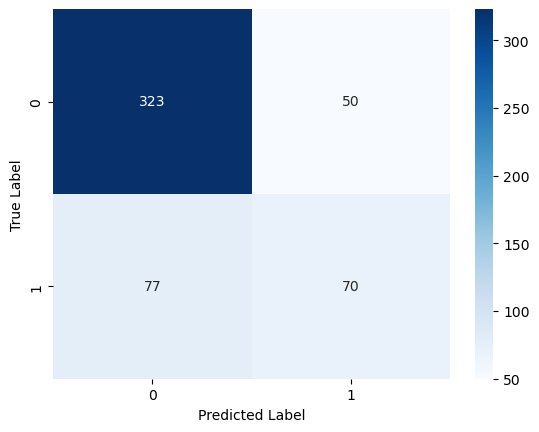

ROC AUC Score: 0.8369079535299374
Balanced Acc: 0.671071109408911


AdaBoostClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       373
           1       0.75      0.52      0.61       147

    accuracy                           0.81       520
   macro avg       0.79      0.72      0.74       520
weighted avg       0.81      0.81      0.80       520

Confusion Matrix:


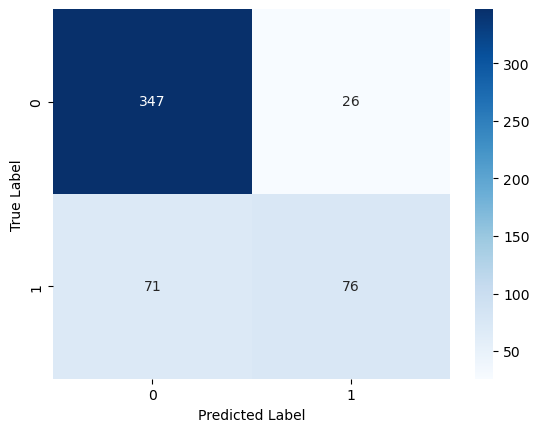

ROC AUC Score: 0.8758001860261531
Balanced Acc: 0.7236508544436542




In [45]:
# Define models
models = [gboost, xgboost, adaboost]

# Loop through models
for model in models:
    # Define pipeline
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    
    # Fit model and make predictions
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    y_pred_proba = estimator.predict_proba(X_test)[:, 1]
    
    # Generate evaluation metrics
    print(model.__class__.__name__)
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))
    print('Balanced Acc:', balanced_accuracy_score(y_test, y_pred))
    print('\n')

## Oversampling

GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       373
           1       0.58      0.81      0.68       147

    accuracy                           0.78       520
   macro avg       0.75      0.79      0.76       520
weighted avg       0.82      0.78      0.79       520

Confusion Matrix:


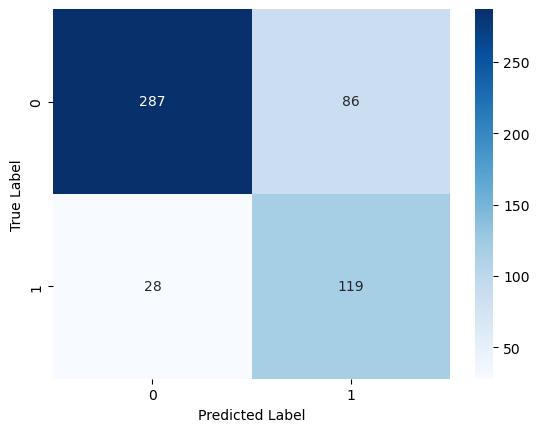

ROC AUC Score: 0.8855209644179387
Balanced Acc: 0.7894804034214222


AdaBoostClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       373
           1       0.60      0.76      0.67       147

    accuracy                           0.79       520
   macro avg       0.75      0.78      0.76       520
weighted avg       0.81      0.79      0.79       520

Confusion Matrix:


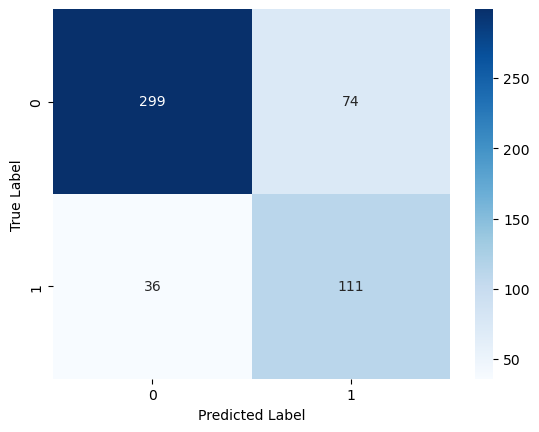

ROC AUC Score: 0.8731283398077729
Balanced Acc: 0.7783553099523992


XGBClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       373
           1       0.54      0.71      0.61       147

    accuracy                           0.74       520
   macro avg       0.70      0.74      0.71       520
weighted avg       0.78      0.74      0.75       520

Confusion Matrix:


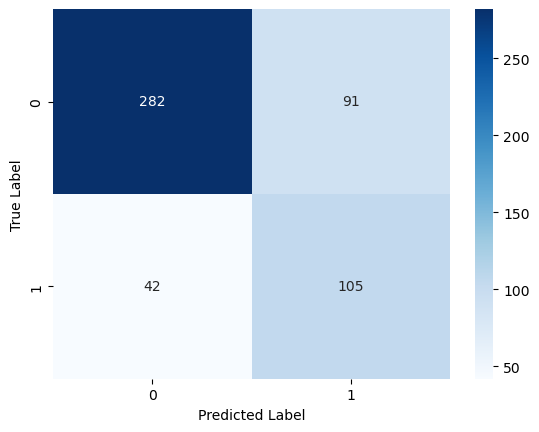

ROC AUC Score: 0.8355218763108461
Balanced Acc: 0.7351589429337418




In [46]:
# Define models
models = [gboost, adaboost, xgboost]

# Loop through models
for model in models:
    # Define pipeline
    estimator = Pipeline([
        ('preprocess', transformer),
        ('resample', ros),
        ('model', model)
    ])
    
    # Fit model and make predictions
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    y_pred_proba = estimator.predict_proba(X_test)[:, 1]
    
    # Generate evaluation metrics
    print(model.__class__.__name__)
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))
    print('Balanced Acc:', balanced_accuracy_score(y_test, y_pred))
    print('\n')

**Random Oversampling**  
Random oversampling adalah teknik oversampling yang populer dalam klasifikasi yang tidak seimbang (imbalanced classification). Teknik ini bekerja dengan menambahkan duplikat acak (random) dari sampel minoritas sehingga jumlah sampel di kelas minoritas menjadi setara dengan kelas mayoritas.

Pengaruh random oversampling terhadap evaluasi metrik sangat tergantung pada dataset dan metrik evaluasi yang digunakan. Secara umum, teknik oversampling dapat meningkatkan performa model pada dataset yang tidak seimbang dengan menghasilkan model yang lebih mampu mengenali dan memprediksi kelas minoritas

## Undersampling

GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       373
           1       0.55      0.80      0.65       147

    accuracy                           0.76       520
   macro avg       0.73      0.77      0.73       520
weighted avg       0.80      0.76      0.77       520

Confusion Matrix:


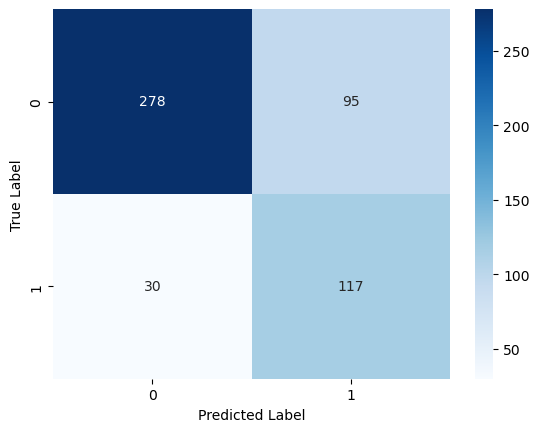

ROC AUC Score: 0.8722985172621327
Balanced Acc: 0.770613339169448


LogisticRegression
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       373
           1       0.54      0.77      0.63       147

    accuracy                           0.75       520
   macro avg       0.71      0.75      0.72       520
weighted avg       0.79      0.75      0.76       520

Confusion Matrix:


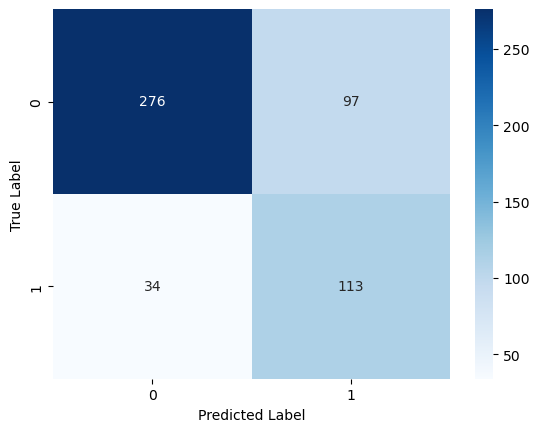

ROC AUC Score: 0.8643559300395761
Balanced Acc: 0.7543269318451241


LGBMClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       373
           1       0.50      0.76      0.60       147

    accuracy                           0.72       520
   macro avg       0.69      0.73      0.69       520
weighted avg       0.77      0.72      0.73       520

Confusion Matrix:


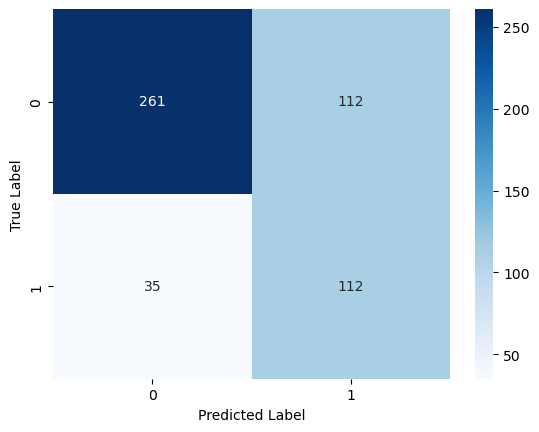

ROC AUC Score: 0.8253998650398497
Balanced Acc: 0.7308183326950083




In [47]:
# Define models
models = [gboost, logreg, lgbm]

# Loop through models
for model in models:
    # Define pipeline
    estimator = Pipeline([
        ('preprocess', transformer),
        ('resample', rus),
        ('model', model)
    ])
    
    # Fit model and make predictions
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    y_pred_proba = estimator.predict_proba(X_test)[:, 1]
    
    # Generate evaluation metrics
    print(model.__class__.__name__)
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))
    print('Balanced Acc:', balanced_accuracy_score(y_test, y_pred))
    print('\n')

**Random undersampling**  
Random undersampling adalah teknik undersampling yang populer dalam klasifikasi yang tidak seimbang (imbalanced classification). Teknik ini bekerja dengan mengurangi jumlah sampel mayoritas secara acak sehingga jumlah sampel di kelas mayoritas menjadi setara dengan kelas minoritas.

Cara kerja dari random undersampling adalah dengan memilih sejumlah sampel acak dari kelas mayoritas untuk dihapus sehingga jumlah sampel pada kelas mayoritas menjadi setara dengan jumlah sampel pada kelas minoritas. Dengan mengurangi jumlah sampel pada kelas mayoritas, teknik ini dapat meningkatkan kemampuan model untuk mengenali dan memprediksi kelas minoritas.

### Model Selection

**Tanpa Sampling**

| Model  | ROC AUC | Balanced Acc       |
|-------|------|------------|
| GBoost  | 0.881855154930605   | 0.7105651912239427   |
| XGBoost | 0.8369079535299374   | 0.671071109408911|
| AdaBoost   | 0.8758001860261531   | 0.7236508544436542    |


**Oversampling**

| Model  | ROC AUC | Balanced Acc       |
|-------|------|------------|
| GBoost  | 0.8855209644179387   | 0.7894804034214222   |
| AdaBoost | 0.8731283398077729   | 0.7783553099523992 |
| XGBoost   | 0.8355218763108461   | 0.7351589429337418    |


**Undersampling**

| Model  | ROC AUC | Balanced Acc       |
|-------|------|------------|
| GBoost  | 0.8722985172621327   | 0.770613339169448   |
| Logreg | 0.8639546971603655   | 0.754947019022086 |
| LGBM   | 0.8253998650398497   | 0.7308183326950083    |

Berdasarkan hasil pengujian dengan membandingkan beberapa model dengan menggunakan oversampling / undersampling / tanpa sampling, didapatkan bahwa nilai ROC AUC dan Balanced Accuracy terbaik berada pada model GradientBoost Classifier dengan Random Over Sampling dengan nilai sebesar:

**GradientBoost Classifier Using Random Oversampling**
- `ROC AUC`: **0.8855209644179387**
- `Balanced Accuracy`: **0.7894804034214222**

**Apa itu GradientBoost Classifier dan Bagaimana Kerja-nya?**

Gradient Boosting Classifier adalah algoritma machine learning yang termasuk dalam kategori ensemble learning. Ensemble learning adalah teknik yang memadukan beberapa model machine learning sederhana untuk menghasilkan model yang lebih kuat.

Secara umum, Gradient Boosting Classifier bekerja dengan cara menggabungkan beberapa model decision tree sederhana yang disebut weak learner untuk membentuk model yang lebih kompleks dan akurat. Weak learner adalah model yang memiliki kemampuan prediksi yang rendah, seperti decision tree yang terdiri dari satu atau dua node.

<img src="https://www.researchgate.net/publication/351542039/figure/fig1/AS:1022852723662850@1620878501807/Flow-diagram-of-gradient-boosting-machine-learning-method-The-ensemble-classifiers.png" width="500" height="500">

Gradient Boosting Classifier menggabungkan beberapa model decision tree sederhana (weak learner) untuk membentuk model yang lebih kompleks dan akurat. Proses training dimulai dengan membuat weak learner pertama dan memprediksi label target pada dataset. Kemudian, kesalahan prediksi dihitung dan digunakan sebagai dasar untuk membuat weak learner kedua. Proses ini diulang dengan menambahkan weak learner baru dan menggabungkannya dengan model sebelumnya hingga mencapai jumlah yang diinginkan atau mencapai tingkat akurasi yang memadai. Pada setiap iterasi, model memperbaiki kesalahan prediksi sebelumnya dengan menempatkan lebih banyak bobot pada sampel yang sulit diprediksi atau mengabaikan sampel yang sudah terprediksi dengan benar. Gradient Boosting Classifier menghasilkan hasil prediksi yang sangat akurat tetapi cenderung overfitting jika hyperparameter tidak dikendalikan dengan baik.

# HyperParameter Tuning Model

### GradientBoost Classifier Hyperparameter

In [49]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [58]:
# RandomizedSearchCV

%time
# hyperparameter untuk GradientBoost
hyperparam = {'modeling__learning_rate': [0.001, 0.01, 0.1, 0.5],
              'modeling__n_estimators': [50, 100, 200, 500],
              'modeling__max_depth': [3, 5, 7, 9],
              'modeling__min_samples_split': sp_randint(2, 20),
              'modeling__min_samples_leaf': sp_randint(1, 20),
              'modeling__max_features': sp_randint(2, 20),
              'modeling__subsample': uniform(0.5, 0.5),
              'modeling__random_state': [42]}

# model
model = GradientBoostingClassifier()

# untuk estimator
pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('resample', ros),
        ('modeling', model)
    ])

randomsearch = RandomizedSearchCV(
    estimator= pipe_model,
    param_distributions= hyperparam,
    cv= 10,
    scoring= 'roc_auc',
    random_state=0,
    n_jobs= -1,
    n_iter= 500
)

randomsearch.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               RobustScaler(),
                                                                               ['previous_cancellations',
                                                                                'booking_changes',
                                                                                'days_in_waiting_list',
                                                                                'required_car_parking_spaces',
                                                                                'total_of_special_requests']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['deposit_type',
                                                                                'customer_type',
                                                                                'mar...
                                        'modeling__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002EA5ACE0100>,
                                        'modeling__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002EA5C7C77C0>,
                                        'modeling__n_estimators': [50, 100, 200,
                                                                   500],
                                        'modeling__random_state': [42],
                                        'modeling__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002EA5AB79300>},
                   random_state=0, scoring='roc_auc')

Pada kode tersebut, terdapat beberapa hyperparameter yang digunakan pada model Gradient Boosting Classifier, yaitu:

- `learning_rate`: parameter yang digunakan untuk mengatur ukuran langkah pada setiap iterasi gradient descent.
- `n_estimators`: parameter yang menentukan jumlah model decision tree yang akan digunakan pada Gradient Boosting.
- `max_depth`: parameter yang mengatur kedalaman maksimum dari setiap decision tree yang dibuat.
- `min_samples_split`: parameter yang menentukan jumlah minimum sampel yang dibutuhkan untuk membagi suatu node.
- `min_samples_leaf`: parameter yang menentukan jumlah minimum sampel yang diperlukan pada suatu leaf node.
- `max_features`: parameter yang mengatur jumlah maksimum fitur yang akan digunakan pada setiap decision tree.
- `subsample`: parameter yang menentukan persentase sampel yang akan diambil secara acak pada setiap iterasi.
- `random_state`: parameter yang digunakan untuk mengontrol inisialisasi angka random pada model.

**Randomseach**

Terdapat beberapa faktor alasan mengapa digunakan-nya Randomsearch sebagai metode hyperparameter tuning pada projek ini diantaranya adalah sebagai berikut:
- Jika terdapat banyak hiperparameter dengan rentang nilai yang luas.
- Jika hiperparameter yang digunakan tidak saling terkait satu sama lain.
- Jika terdapat beberapa hiperparameter yang memiliki dampak signifikan pada performa model.
- Jika jumlah hiperparameter sedikit dan setiap hiperparameter saling terkait, maka grid search dapat menjadi pilihan yang lebih baik.

Dari konfigurasi hyperparameter yang diberikan, tampaknya ada beberapa hyperparameter dengan rentang nilai yang luas dan beberapa hyperparameter yang memiliki distribusi acak.

Jika jumlah hiperparameter sedikit dan setiap hyperparameter saling terkait, maka grid search dapat menjadi pilihan yang lebih baik.

In [59]:
randomsearch.best_params_

{'modeling__learning_rate': 0.1,
 'modeling__max_depth': 3,
 'modeling__max_features': 7,
 'modeling__min_samples_leaf': 3,
 'modeling__min_samples_split': 8,
 'modeling__n_estimators': 100,
 'modeling__random_state': 42,
 'modeling__subsample': 0.704647656117381}

GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       373
           1       0.59      0.84      0.69       147

    accuracy                           0.79       520
   macro avg       0.76      0.81      0.77       520
weighted avg       0.83      0.79      0.80       520

Confusion Matrix:


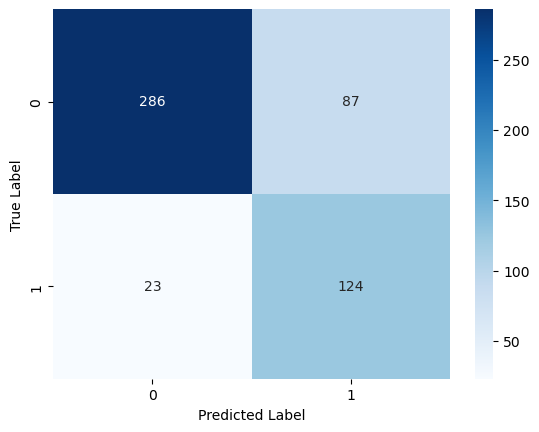

ROC AUC Score: 0.8888128978132808
Balanced Score: 0.8051467235687841




In [60]:
# Define model and pipeline
model = GradientBoostingClassifier(subsample=0.704647656117381,
                                   n_estimators=100,
                                   max_features=7,
                                   max_depth = 3,
                                   learning_rate=0.1,
                                   min_samples_leaf=3, 
                                   min_samples_split=8,
                                   random_state=42)
estimator = Pipeline([
    ('preprocess', transformer),
    ('resample', ros),
    ('model', model)
])

# Fit model and make predictions
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
y_pred_proba = estimator.predict_proba(X_test)[:, 1]

# Generate evaluation metrics
print(model.__class__.__name__)
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))
print('Balanced Score:', balanced_accuracy_score(y_test, y_pred))
print('\n')

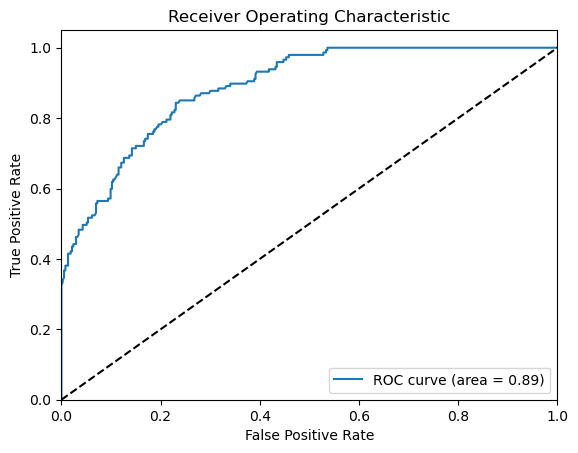

In [61]:
# Import necessary libraries
from sklearn.metrics import roc_curve

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Berdasarkan hasil hyperparameter tuning yang telah dilakukan di model GradientBoost Classifier dengan Random Oversampling, didapatkan bahwa nilai `ROC AUC Score yang dihasilkan adalah 0.89`, yang menunjukkan model memiliki kinerja yang baik dalam membedakan antara kelas-kelas tersebut.

Dalam hal ini, `Balanced Score yang dihasilkan adalah 0.805`, yang menunjukkan model memiliki kinerja yang baik dalam memprediksi kedua kelas dengan seimbang meskipun terdapat ketidakseimbangan jumlah sampel antara kelas-kelas tersebut.

# Feature Importance

In [62]:
estimator['model'].feature_importances_

array([0.13060857, 0.08878488, 0.01957571, 0.26766053, 0.04956382,
       0.14747607, 0.00237311, 0.01455034, 0.05516579, 0.0100688 ,
       0.01100352, 0.00581451, 0.00889904, 0.02558453, 0.00350176,
       0.0023616 , 0.02868988, 0.0156882 , 0.11262935])

In [63]:
estimator['preprocess'].get_feature_names_out()

array(['scaler__previous_cancellations', 'scaler__booking_changes',
       'scaler__days_in_waiting_list',
       'scaler__required_car_parking_spaces',
       'scaler__total_of_special_requests',
       'onehot__deposit_type_Non Refund',
       'onehot__deposit_type_Refundable', 'onehot__customer_type_Group',
       'onehot__customer_type_Transient',
       'onehot__customer_type_Transient-Party',
       'onehot__market_segment_Direct', 'onehot__market_segment_Groups',
       'onehot__market_segment_Offline TA/TO',
       'onehot__market_segment_Online TA',
       'onehot__reserved_room_type_low', 'onehot__reserved_room_type_mid',
       'onehot__booking_type_online', 'onehot__booking_type_other',
       'remainder__is_domestic'], dtype=object)

In [64]:
df_imp = pd.DataFrame({
    'feature': estimator['preprocess'].get_feature_names_out(),
    'importance': estimator['model'].feature_importances_*100
})

df_imp = df_imp.sort_values('importance', ascending=False)
df_imp

,feature,importance
3,scaler__required_car_parking_spaces,26.766053
5,onehot__deposit_type_Non Refund,14.747607
0,scaler__previous_cancellations,13.060857
18,remainder__is_domestic,11.262935
1,scaler__booking_changes,8.878488
8,onehot__customer_type_Transient,5.516579
4,scaler__total_of_special_requests,4.956382
16,onehot__booking_type_online,2.868988
13,onehot__market_segment_Online TA,2.558453
2,scaler__days_in_waiting_list,1.957571


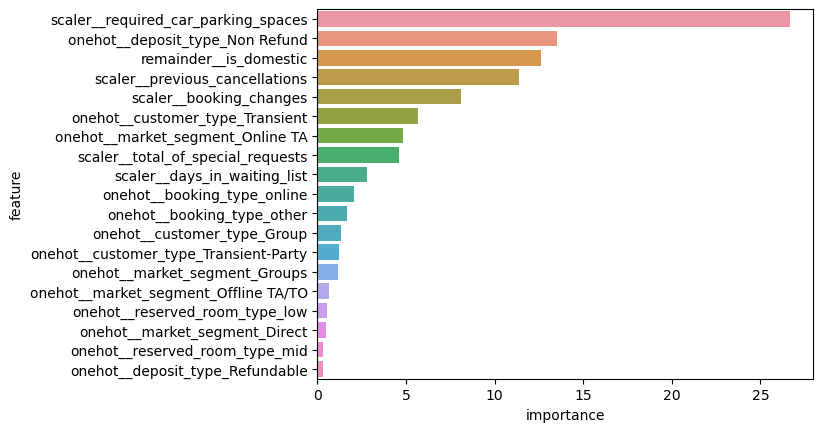

In [57]:
sns.barplot(data=df_imp, x = 'importance', y = 'feature');

Tabel di atas merupakan hasil feature importance dari suatu model yang digunakan untuk memprediksi apakah sebuah reservasi hotel akan dibatalkan atau tidak. Terdapat 19 fitur yang digunakan dalam model tersebut dan setiap fitur diberi skor berdasarkan pengaruhnya dalam membuat prediksi. Semakin besar skornya, semakin besar pula pengaruhnya terhadap prediksi yang dihasilkan.

Dari tabel tersebut, dapat dilihat bahwa fitur yang paling berpengaruh dalam membuat prediksi adalah `scaler__required_car_parking_spaces` dengan skor 26.766053. Fitur ini mengindikasikan jumlah tempat parkir mobil yang diperlukan oleh tamu. Fitur ini memiliki pengaruh paling besar dalam memprediksi apakah suatu reservasi hotel akan dibatalkan atau tidak.

Selanjutnya, fitur kedua yang paling berpengaruh adalah `onehot__deposit_type_Non Refund` dengan skor 14.747607, yang menunjukkan apakah tamu telah membayar deposit atau tidak. Kemudian, fitur ketiga yang paling berpengaruh adalah 
`scaler__previous_cancellations` dengan skor 13.060857, dan fitur keempat adalah `remainder__is_domestic` dengan skor 11.262935, yang menunjukkan apakah tamu berasal dari dalam negeri atau bukan.

Seluruh fitur yang terdapat dalam tabel ini dapat membantu untuk memahami faktor-faktor apa saja yang mempengaruhi keputusan tamu dalam membatalkan reservasi hotel dan bagaimana fitur-fitur ini dapat digunakan dalam membuat prediksi yang lebih akurat.

# Kesimpulan, Rekomendasi & Saran

## Kesimpulan

**Bisnis**  
Berdasarkan tabel feature importance, dapat diidentifikasi bahwa fitur-fitur yang paling penting dalam memprediksi pembatalan reservasi hotel adalah:

- `required_car_parking_spaces`: fitur ini memiliki dampak paling signifikan dalam memprediksi apakah reservasi akan dibatalkan atau tidak. Hal ini menunjukkan bahwa pelanggan yang memerlukan tempat parkir mungkin lebih cenderung untuk tidak membatalkan reservasi mereka.
- `deposit_type_Non Refund`: fitur ini memiliki dampak besar kedua terhadap prediksi pembatalan reservasi. Hal ini menunjukkan bahwa pelanggan yang tidak dapat mengembalikan deposito mereka lebih cenderung untuk membatalkan reservasi mereka.
- `is_domestic`: fitur ini juga memiliki dampak besar dalam memprediksi pembatalan reservasi. Hal ini menunjukkan bahwa pelanggan yang bukan dari negara asal hotel (mungkin turis) lebih cenderung untuk membatalkan reservasi mereka.
- `previous_cancellations`: fitur ini memiliki dampak cukup besar dalam memprediksi pembatalan reservasi. Hal ini menunjukkan bahwa pelanggan yang pernah membatalkan reservasi di masa lalu lebih cenderung untuk membatalkan reservasi di masa depan.
- `booking_changes`: fitur ini juga memiliki dampak cukup besar dalam memprediksi pembatalan reservasi. Hal ini menunjukkan bahwa pelanggan yang sering mengubah reservasi mereka lebih cenderung untuk membatalkan reservasi mereka.

Berikut beberapa solusi yang dapat membantu mengurangi kemungkinan pembatalan reservasi oleh pelanggan:

- Memastikan ketersediaan tempat parkir: Mengingat fitur required_car_parking_spaces memiliki dampak signifikan dalam memprediksi pembatalan reservasi, hotel dapat memastikan bahwa mereka memiliki jumlah tempat parkir yang mencukupi untuk memenuhi kebutuhan pelanggan.

- Kebijakan deposit yang jelas: Dalam hal deposit_type_Non Refund, hotel dapat memberikan kebijakan deposit yang jelas dan transparan kepada pelanggan, sehingga mereka dapat membuat keputusan yang tepat dan mempertimbangkan risiko jika mereka memilih untuk membatalkan reservasi.

- Meningkatkan pengalaman pelanggan: Dalam hal is_domestic, hotel dapat memastikan bahwa mereka memberikan pengalaman yang memuaskan dan menyenangkan bagi tamu dari luar negeri. Ini dapat mencakup pelayanan yang baik, pilihan makanan yang beragam, dan memberikan informasi yang berguna tentang kota dan lokasi hotel.

- Kebijakan pembatalan yang fleksibel: Hotel dapat mempertimbangkan untuk memberikan kebijakan pembatalan yang fleksibel kepada pelanggan, terutama bagi mereka yang telah mengalami pembatalan reservasi di masa lalu. Hal ini dapat meningkatkan kepercayaan pelanggan dan memotivasi mereka untuk tetap menginap di hotel tersebut.

- Mengurangi perubahan reservasi: Hotel dapat mengurangi jumlah perubahan reservasi yang dilakukan oleh pelanggan dengan memberikan informasi yang jelas tentang kebijakan perubahan reservasi dan memastikan bahwa pelanggan telah memahami informasi tersebut. Ini dapat membantu mengurangi kemungkinan pembatalan reservasi oleh pelanggan.

Dalam permasalahan di atas, model tersebut memiliki nilai ROC-AUC sebesar 0.8888 dan Balanced Accuracy sebesar 0.8051. Ini menunjukkan bahwa model tersebut cukup baik dalam membedakan antara pelanggan yang akan melakukan pembatalan dan yang tidak.

Dengan menggunakan model tersebut, pihak hotel dapat mengidentifikasi pelanggan yang berpotensi melakukan pembatalan dan melakukan tindakan pencegahan seperti menghubungi pelanggan, memberikan diskon atau menawarkan pilihan alternatif seperti berikut:
- Diskon khusus: Memberikan diskon khusus kepada pelanggan yang memiliki riwayat pembatalan reservasi yang tinggi dapat menjadi insentif bagi mereka untuk tetap memesan dan tidak membatalkan reservasi.

- Upgrade kamar gratis: Memberikan upgrade kamar gratis kepada pelanggan yang cenderung melakukan pembatalan reservasi dapat memberikan motivasi tambahan bagi mereka untuk tetap menginap di hotel.

- Poin loyalty program: Jika hotel memiliki program loyalty yang dapat memberikan poin atau hadiah kepada pelanggan, hotel dapat memberikan poin tambahan kepada pelanggan yang cenderung berpotensi melakukan pembatalan sebagai bentuk insentif tambahan.

- Layanan khusus: Menawarkan layanan khusus seperti spa gratis atau sarapan gratis untuk pelanggan yang cenderung berpotensi melakukan pembatalan dapat menjadi insentif yang menarik bagi mereka untuk tetap memesan.

Namun, perlu diingat bahwa promosi harus diberikan dengan bijaksana dan tidak berlebihan, sehingga tidak merugikan bisnis hotel. Selain itu, promosi harus juga diberikan secara selektif dan tidak kepada semua pelanggan, sehingga tidak merusak reputasi hotel sebagai bisnis yang profesional dan bertanggung jawab.

Selain itu, model yang baik juga dapat membantu pihak hotel mengurangi risiko overbooking dan kehilangan peluang untuk menjual kamar hotel kepada pelanggan lain. Dengan menggunakan model untuk memprediksi pembatalan, pihak hotel dapat mengelola persediaan kamar secara lebih efektif dan efisien, sehingga dapat meningkatkan keuntungan dan reputasi hotel.

Bila seandainya biaya untuk persiapan kamar hotel untuk calon pelanggan yang melakukan booking hotel adalah sebesar 25 EUR, dan andaikan jumlah calon pelanggan yang dimiliki untuk suatu kurun waktu sebanyak 500 orang (dimana andaikan 250 orang membatalakan booking, dan 250 tidak membatalkan booking. Maka perhitungannya kurang lebih akan seperti ini:

Total Biaya = (Jumlah Pelanggan Tidak Akan Membatalkan x Biaya Persiapan) + (Jumlah Pelanggan Akan Membatalkan x Biaya Persiapan)


Tanpa Model (Semua Kamar yang di booking akan dilakukan persiapan):
- Total biaya = (250 x 25 EUR) + (250 x 25 EUR) = 12500 EUR
- Total calon pelanggan yang menginap  = 250
- Total calon pelanggan yang membatalakan = 250
- Karena terdapat total calon pelanggan yang membatalkan sebesar 250, maka biaya persiapan akan terbuang sia sia.
- Total Kerugian = 6250 EUR

Dengan Model (Hanya kamar yang akan di tempati oleh calon pelanggan yang di persiapkan):
- Total biaya = (210 x 25 EUR) + (58 x 25 EUR) = 5250 EUR + 1450 EUR = 6700 EUR
- Total calon pelanggan yang menginap = 210 (karena recall 1/yg tertarik itu -> 250 x 0.84)
- Total calon pelanggan yang membatalkan = 40 (karena recall 1/yg tertarik itu 250 x 0.84)
- Biaya yang terbuang => 58 x 25 EUR = 1450 EUR (berdasarkan recall 0/yg tidak tertarik (58 orang -> 0.23 x 250))
- Jumlah penghematan => 193 x 25 EUR = 4825 EUR (yang dihitung hanya yang memang membatalkan saja (193 orang -> 0.77 x 250))

Dari perhitungan tersebut, terlihat bahwa dengan menggunakan model, perusahaan akan menghemat biaya persiapan kamar yang cukup besar. Dengan demikian, model tersebut dapat memberikan keuntungan bagi pihak hotel dalam mengelola bisnis mereka dengan lebih efektif dan efisien, sehingga dapat mengoptimalkan keuntungan dan meningkatkan kepuasan pelanggan.



**Model**  
Berdasarkan hasil evaluasi model, `ROC AUC Score yang diperoleh adalah 0.89`, yang menunjukkan bahwa model memiliki kemampuan yang baik untuk membedakan antara kelas positif dan negatif. Sementara itu, `Balanced Score yang diperoleh adalah 0.805`, menunjukkan bahwa model mampu mengklasifikasikan dengan baik kelas yang tidak seimbang.

Dengan demikian, dapat disimpulkan bahwa model memiliki kinerja yang cukup baik dalam memprediksi apakah sebuah pemesanan hotel akan dibatalkan atau tidak. Namun, tetap diperlukan evaluasi lebih lanjut terhadap model ini seperti melakukan validasi dengan data baru dan melakukan tuning hyperparameter untuk memastikan kinerja model yang optimal. Selain itu, model juga perlu dipertimbangkan dalam konteks bisnis dan perlu dilakukan penilaian ulang terkait dengan biaya dan manfaat yang terkait dengan penggunaan model ini untuk membantu dalam pengambilan keputusan.

Oleh karena itu, kesimpulan yang dapat diambil adalah model yang dibangun sudah cukup baik dalam membedakan kelas positif dan negatif, serta masih mampu mengatasi masalah kelas imbalance dengan baik. Namun, tetap diperlukan peningkatan performa model terutama pada `peningkatan nilai precision` untuk mengurangi false positive rate yang berpotensi mengakibatkan kerugian bagi pihak hotel.

# Rekomendasi

**Business**
1. Menyediakan fasilitas parkir yang memadai dan menarik bagi pelanggan, sehingga pelanggan yang memerlukan tempat parkir merasa nyaman dan lebih mungkin untuk mempertahankan reservasi mereka.
2. Memperhatikan kebijakan deposito dan menawarkan kebijakan yang dapat meminimalkan risiko pembatalan. Misalnya, menawarkan kebijakan pengembalian dana yang fleksibel untuk pelanggan atau menawarkan paket dengan harga yang lebih tinggi yang menawarkan kebijakan pengembalian dana yang lebih menguntungkan.
3. Memperluas strategi pemasaran untuk menarik lebih banyak pelanggan dari negara asing dan menyesuaikan pelayanan dengan kebutuhan mereka.
4. Memantau dan mengevaluasi kebijakan pembatalan yang ada dan mempertimbangkan penyesuaian atau pemberian insentif khusus kepada pelanggan yang pernah membatalkan reservasi di masa lalu.
5. Menerapkan sistem yang memfasilitasi perubahan reservasi pelanggan dan memberikan informasi yang jelas dan tepat waktu tentang kebijakan pembatalan dan perubahan.

**Model**  
Berdasarkan hasil evaluasi metrics dan classification report di atas, model memiliki akurasi sebesar 0.79 dengan precision sebesar 0.59, recall sebesar 0.84 dan f1-score sebesar 0.69. Hal ini menunjukkan bahwa model dapat memprediksi dengan baik untuk kelas negatif, tetapi masih perlu ditingkatkan performanya untuk kelas positif.

Saran yang dapat diberikan adalah melakukan tuning pada model untuk meningkatkan performa pada kelas positif dengan mempertimbangkan kembali pemilihan fitur yang digunakan. Selain itu, sebaiknya dilakukan pengumpulan data lebih banyak untuk meningkatkan akurasi dan performa model.